## Compare 3 models on samples from binomial distribution

In [1]:
import pomegranate as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import binom
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("paper")


## Generate test samples from Binomial Distro

In [11]:
n = 100
p1 = 0.3
p2 = 1 - p1

# each sample is a number of successes over n trials
x1 = np.random.binomial(n, p1, 400)
x2 = np.random.binomial(n, p2, 400)
x = np.concatenate((x1,x2)).flatten()
x = x[x > 50]
print(x)

[71 65 72 73 68 72 71 63 67 72 68 70 65 70 62 62 72 66 71 64 77 65 69 72
 74 72 76 70 73 70 69 78 72 70 72 65 71 74 72 67 71 66 65 67 71 71 67 71
 68 69 73 68 68 71 76 65 63 70 69 75 74 61 75 64 68 63 70 76 72 63 71 64
 71 70 78 68 70 72 67 73 83 74 72 70 65 69 68 70 68 78 63 67 69 63 69 67
 70 66 68 72 68 65 71 69 66 63 71 72 76 64 72 75 71 75 67 65 67 68 66 62
 71 73 73 68 70 62 71 76 68 81 65 69 64 70 66 68 69 69 70 67 75 61 74 72
 68 71 68 77 68 71 75 75 67 67 65 81 68 71 65 71 66 72 71 67 65 74 67 71
 67 64 65 74 63 70 69 68 61 68 69 68 62 64 73 73 77 69 72 64 65 74 73 75
 74 67 70 81 71 70 70 76 67 68 72 68 69 69 72 67 74 73 75 65 64 75 67 65
 76 67 73 67 71 73 74 71 72 69 69 71 65 73 71 64 74 64 82 70 71 73 74 67
 71 73 68 71 72 69 64 68 69 68 77 76 68 77 73 67 70 63 65 75 74 70 65 65
 71 71 78 75 70 63 69 77 64 82 66 73 72 75 72 69 68 77 74 66 67 69 77 71
 67 64 67 73 66 63 62 73 70 77 68 68 69 70 67 70 77 63 68 62 70 68 66 76
 71 66 60 70 68 71 73 73 77 75 72 68 75 72 70 65 65

## Compare 3 models: Discrete distro, Gaussian distro, Binomial Distro

In [12]:
# create dummy (based on x1) probabilities for discrete model.
bins = np.arange(0,100,1)
hist, bins = np.histogram(x1, bins=bins, density=True)
pmf = dict(zip(bins, hist))
# init discrete model 
disc_model = pm.DiscreteDistribution(pmf)
# fit the actual data
disc_model.fit(x)
# get the actual pmf for plotting
p_d = []
p_bin = []

# P estimtion for binomial distribution
trials = 100    # this should be derived from the average of depth of samples considered
num_samples = len(x)    # this is the number of samples in a dataset
p_mle = np.sum(x)/(trials*num_samples)


for i in range(0,100):
    # prepare a probability vector for discrete model
    p_d.append(disc_model.probability(i))
    # prepare a probability vector for binomial model
    p_bin.append(binom.pmf(i,trials,p_mle))

# init Gaussian distribution
norm_model = pm.NormalDistribution(1,1)
# fit the actual data
norm_model.fit(x)
p_g = norm_model.probability(np.arange(0,100,1))


## Plot results. Note: The Binomial parameters were not estimated but provided by me.

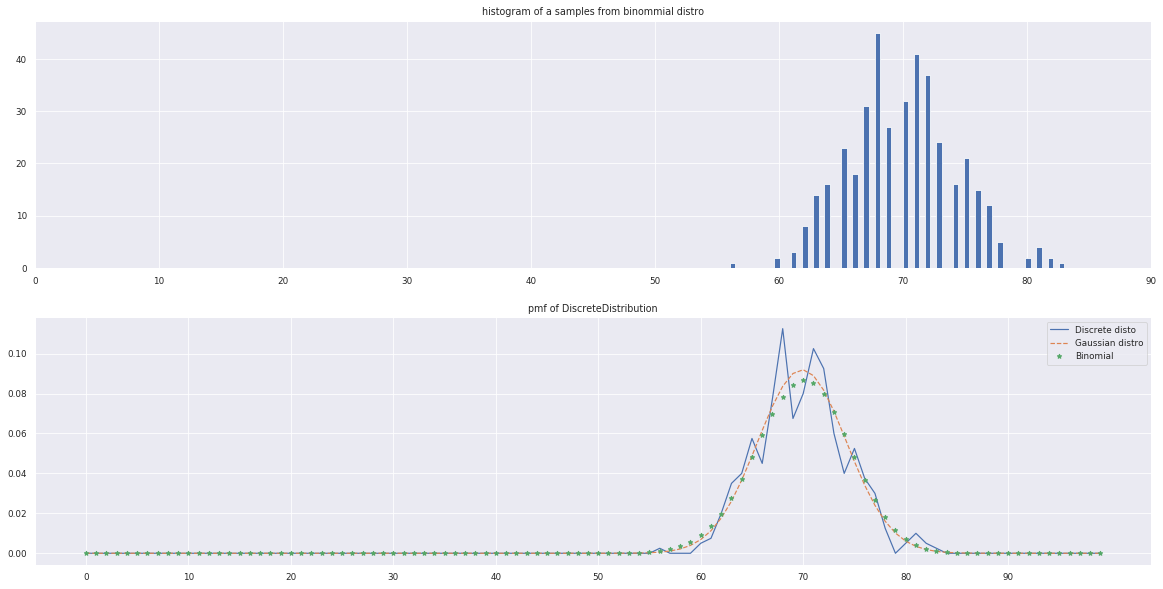

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title('histogram of a samples from binommial distro')
plt.hist(x, bins=60)
plt.xticks(np.arange(0,100,10))

plt.subplot(212)
plt.title('pmf of DiscreteDistribution')
legend = ['Discrete disto', 'Gaussian distro', 'Binomial']
plt.plot(np.arange(0,100,1), p_d)
plt.plot(np.arange(0,100,1), p_g, '--')
plt.plot(np.arange(0,100,1), p_bin, '*')

plt.xticks(np.arange(0,100,10))
plt.legend(legend)
plt.show()
plt.close()


## print parameters of estimated Binomial and Gaussian 

In [5]:
print(f'gaussian mixture estimated mean: {norm_model.parameters[0]}')
print(f'estimated p mle for binomial: {p_mle*100}')

gaussian mixture estimated mean: 49.7125
estimated p mle for binomial: 49.7125


## Now we work with  real data

estimate for the proportion of major strain:

\begin{align}
    \hat{p}_{major} = \frac{\textrm{total success}}{\textrm{total trials}}
    = \frac{ \sum_i \max\{n_a^{(i)}, n_c^{(i)}, n_t^{(i)}, n_g^{(i)}\}}{\sum_i d_i}
\end{align}

for $d_i$ depth at position $i$ (number of trials),  
$50 \leq n_k^{(i)} \leq 90$ number of reads supporting letter $k$.  
$\max\{n_a^{(i)}, n_c^{(i)}, n_t^{(i)}, n_g^{(i)}\}$ number of success at position $i$ (getting major strain)
$$\hat{p}_{minor} = 1 - \hat{p}_{major}$$

In [20]:
pathFile = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_synth_samples/output/70_16/freqVec.csv'
# pathFile = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/44_17/freqVec.csv'

freqVec = np.loadtxt(open(f'{pathFile}', 'rb'), delimiter=',', dtype=int)
# filter out low depth
freqVec = freqVec[freqVec[:,5] > 80]
freqVec = freqVec[freqVec[:,0:4].max(axis=1) <= 90]
flatFreqVec = freqVec[:,:4].flatten()

freqVecSorted = freqVec.copy()
# we sort freqVec and pick the largest element for esimation of p
freqVecSorted[:,:4] = np.sort(freqVecSorted[:,:4])

# estimate trials
trials = int(np.sum(freqVec[:,5])/len(freqVec[:,5]))
# estimate p 
p = np.sum(freqVecSorted[:,3]*0.01*freqVecSorted[:,5])/np.sum(freqVecSorted[:,5])
print(f'estimated p mle for major strain: {p}, estimated n: {trials}')


estimated p mle for major strain: 0.6948939214181032, estimated n: 98


## Gaussian fit

In [18]:
# flatten data set and take upper half of it
flatFreqVec_half =  flatFreqVec.copy()
flatFreqVec_half = flatFreqVec_half[flatFreqVec_half >= 50]

norm_model = pm.NormalDistribution(1,1)
# fit the actual data
norm_model.fit(flatFreqVec_half)
mu = norm_model.parameters[0]
sd = norm_model.parameters[1]
print(f'Gaussian estimated mean for major strain: {mu}, estimated SD: {sd}')


Gaussian estimated mean for major strain: 69.53767123287672, estimated SD: 4.310144777324931


## plot real data

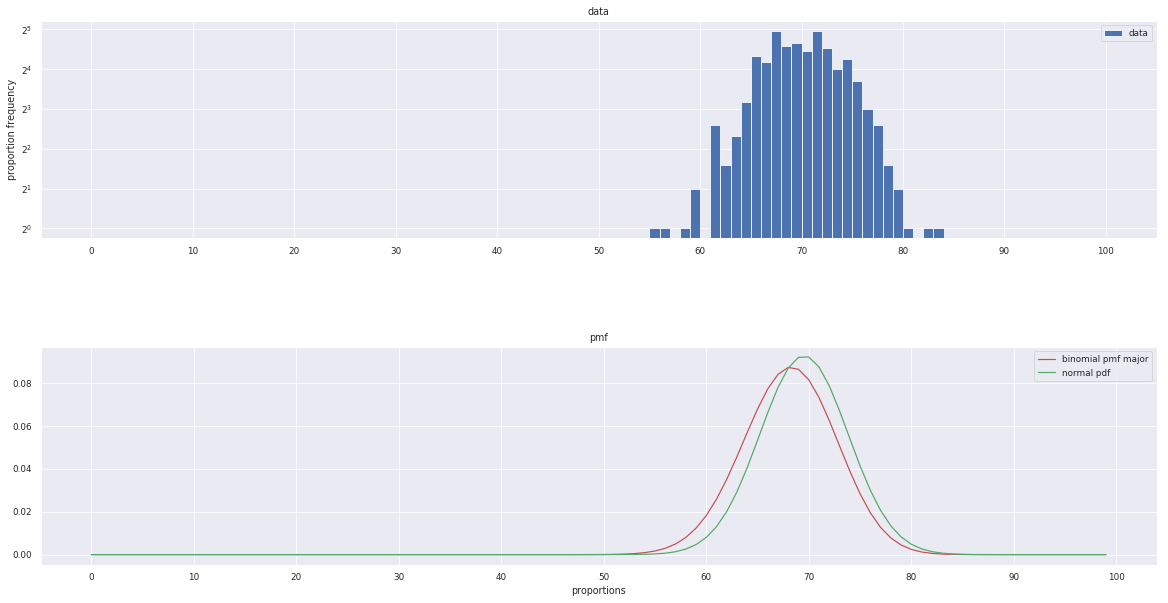

In [23]:
# prepare a probability vector for binomial model
p_bin_1 = []
p_bin_2 = []

for i in range(0,100):
    p_bin_1.append(binom.pmf(i,trials,p))
    
    
fig, axs = plt.subplots(2,1)
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=0.5)
numBins = 100
axs[0].hist(flatFreqVec_half, bins=numBins, range=(0,numBins), facecolor='b')
axs[0].set_yscale('log', basey=2, nonposy='clip')
axs[0].set_title('data')
axs[0].set_ylabel("proportion frequency")
axs[0].set_xticks(range(0, numBins+1, 10))
axs[0].legend(['data'])

# Plot GMM pdf
axs[1].set_title('pmf')
axs[1].set_xticks(range(0, numBins+1, 10))
x_axis = np.arange(0,numBins, 1).reshape(-1,1)
axs[1].plot(x_axis, p_bin_1, 'r')
# axs[1].plot(x_axis, p_bin_2, 'g')
axs[1].plot(x_axis, norm_model.probability(x_axis), 'g')
axs[1].set_xlabel('proportions')
axs[1].legend(['binomial pmf major', 'normal pdf'])
